In [1]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter 
from sklearn.linear_model import LinearRegression
from string import punctuation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxnbf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("cleaned.csv")
df.head()

corpus = list(df["description"])

In [3]:
def tokenize(desc):
    tokens = nltk.word_tokenize(desc)

    # filter out all tokens of length 1?
    return tokens

df["description"] = df["description"].apply(tokenize)

df.head()

,annual_salary,description
0,48880.0,"[many, industries, hurt, last, years, people, ..."
1,39500.0,"[Provide, clerical, administrative, support, m..."
2,100000.0,"[United, Staffing, Solutions, partnering, one,..."
3,38000.0,"[looking, responsible, Administrative, Assista..."
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R..."


In [4]:
# for RNN it was recommended we use lengths of 50 tokens.
def lengths(desc):
    return len(desc)

df["len"] = df["description"].apply(lengths)

df.head()

,annual_salary,description,len
0,48880.0,"[many, industries, hurt, last, years, people, ...",170
1,39500.0,"[Provide, clerical, administrative, support, m...",62
2,100000.0,"[United, Staffing, Solutions, partnering, one,...",55
3,38000.0,"[looking, responsible, Administrative, Assista...",106
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R...",96


<Axes: ylabel='Frequency'>

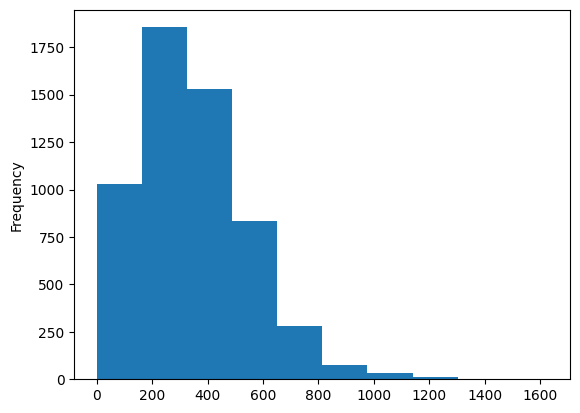

In [5]:
from collections import Counter

# print(Counter(df["len"]).keys())
# print(df.shape)

df["len"].plot.hist()


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer() 
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) 
# print(tfidf_matrix.toarray())
# print(Counter(tfidf_matrix.toarray()[3]))

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, list(df["annual_salary"]))

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))


model = LinearRegression()
model.fit(X_train, y_train)

model.coef_

# index = 9
# pred = model.predict([X_test[index]])

# print(y_test[index], pred[0])


(4240, 56824)
(1414, 56824)
4240
1414


LinearRegression()

In [7]:
index = 1
pred = model.predict(X_test[index])

print(y_test[index], pred[0])

70000.0 78638.0004501741


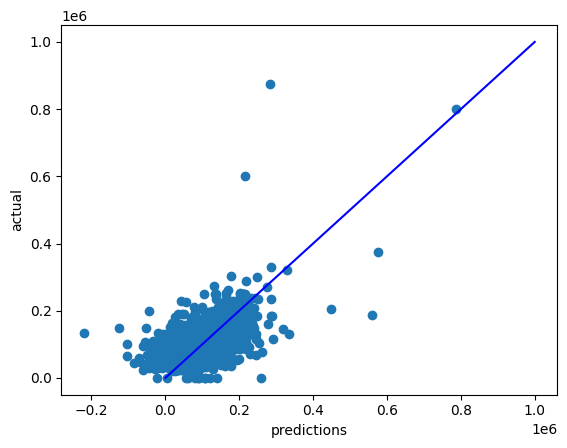

In [10]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

x = range(0, 1000000)
plt.plot(x, x, c="b")
# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()


# compare the actual and predicton in some way (ratio or subtraction)
# investigate the confusion matrix
# investigate the most "confused" items
# use coefficients from LR to reduce features for future models, and iterate 
# use tables to track parameters to the results from the models
# https://jalammar.github.io/explaining-transformers/

In [ ]:
#bag of words
def featurize(vocab, tokenized_data):

    # use min_df or max_features?
    vectorizer = CountVectorizer(vocabulary=vocab, binary=False,max_features=200)

    data = []
    
    for text in tokenized_data:
        data.append(" ".join(text))

    X = vectorizer.fit_transform(data)

    return X.toarray(), vectorizer.get_feature_names_out()

featurized_data, count_vectorizer_vocab = featurize(None, list(df["description"]))


print(len(count_vectorizer_vocab))

56824


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(featurized_data, list(df["annual_salary"]))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

4240
1414
4240
1414


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
index = 9
pred = model.predict([X_test[index]])

print(y_test[index], pred[0])

66000.0 58330.19843590931


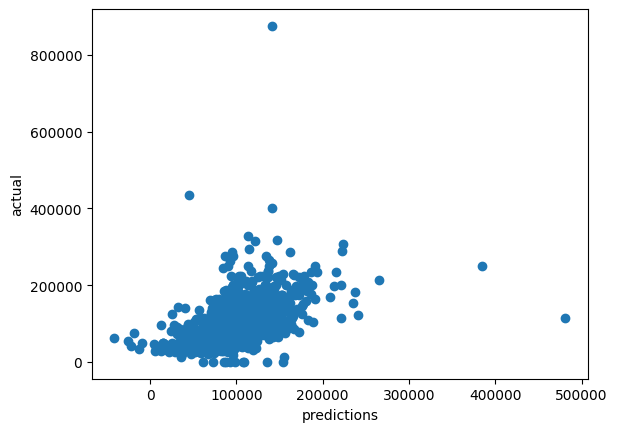

In [ ]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()

In [ ]:
len(preds)

1414